# Datathon 2020 Abraca-data


Este es el notebook con los procesos utilizados para tratar de predecir los casos de COVID-19 por pais y dias despues de comenzada la pandemia


## Librerias y Prep

In [ ]:
!pip install scikit-optimize

In [ ]:
import numpy as np
import pandas as pd
import regex as re
from datetime import datetime
import matplotlib as mtpl
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression,BayesianRidge,Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error,make_scorer,SCORERS
from sklearn.model_selection import cross_val_score,KFold,cross_val_predict,cross_validate
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.plots import plot_convergence,plot_evaluations
from skopt.utils import use_named_args
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [ ]:
mtpl.rcParams['figure.figsize'] = [15, 4]

In [ ]:
strat_k_fold = KFold(n_splits=3, shuffle=True, random_state=2020)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


En el drive del datathon, subimos los archivos a utilizar y los tenemos accesibles aqui:

In [ ]:
!ls "/content/drive/My Drive/Datathon 2020"
#!ls "content/drive/Shared with me/Datathon 2020/"

 data			       'Slides a cambiar.pptx'
'Datathon 2020 – Reto 2.pptx'  'Untitled Diagram (1).png'
'Datathon Abracadata.ipynb'    'Untitled Diagram (2).png'
'Flujo Modelos.jpg'	       'Untitled Diagram.png'
 logos


## Cargando data y datos complementarios


Cuando nos pasen la data y tengamos datasets propios elaborados, en esta seccion se homologa esa data ya procesada con la data que ya tendremos del concurso, para consolidar todo, al final debe declararse X e Y, en donde X es la matriz de variables e Y es el vector de la variable objetivo.

In [ ]:
base=pd.read_csv('/content/drive/My Drive/Datathon 2020/data/DATA_RETO_2.csv', encoding = 'iso-8859-1',quotechar='"')
continent=pd.get_dummies(base['continent'])
who_region=pd.get_dummies(base['who_region'])
base=pd.concat([base,continent,who_region],axis=1)
#base=base[base.iso.notnull()]

Lo primero que debemos hacer es reemplazar los ceros en algunas variables por NaNs, ya que es imposible (o en algunos casos solo poco probable) que sean 0 (median_age,aged_65_older,aged_70_older)

In [ ]:
base[['median_age','aged_65_older','aged_70_older','cvd_death_rate','life_expectancy']]=base[['median_age','aged_65_older','aged_70_older','cvd_death_rate','life_expectancy']].replace(0,np.nan)

Luego de hacer esto, inspeccionemos cuantos valores faltantes tenemos para cada variable

In [ ]:
cols_with_missings = []
for col in base.columns:
    if ~(base.dtypes[col]==np.object):
        missings = np.sum(pd.isna(base[col]))
        print(col, ':', missings)
        if missings:
            cols_with_missings += [col]

country : 0
country_code : 1
iso : 0
date : 0
continent : 0
who_region : 0
day_of_infection : 0
latitude : 6
longitude : 6
population : 0
population_density : 7
median_age : 20
aged_65_older : 21
aged_70_older : 21
gdp_per_capita : 22
extreme_poverty : 82
cvd_death_rate : 19
diabetes_prevalence : 5
female_smokers : 63
male_smokers : 63
handwashing_facilities : 111
hospital_beds_per_thousand : 5
life_expectancy : 2
border_closure : 0
wear_protective_gear_in_public_requirement : 0
businesses_and_public_services_closure : 0
curfews : 0
economic_measures : 0
suspension_international_flights : 0
imports_exports_limit : 0
gatherings_limit : 0
partial_lockdown : 0
schools_closure : 0
established_emergency : 0
quarantine_isolation_policies : 0
full_lockdown : 0
mass_testing : 0
checkpoints_within_the_country : 0
military_deployment : 0
cumulative_cases : 0
Africa : 0
Asia : 0
Europe : 0
North America : 0
Oceania : 0
South America : 0
AFRO : 0
AMRO : 0
EMRO : 0
EURO : 0
SEARO : 0
WPRO : 0


Para complementar los missing values, tratamos de conseguir fuentes de información alterna para tratar de llenar los missing values que teniamos

In [ ]:
variables_adicionales=pd.read_csv('/content/drive/My Drive/Datathon 2020/data/otros_indicadores/otros_indicadores.csv', encoding = 'iso-8859-1',sep=',')
variables_adicionales['turismo']=np.where(variables_adicionales['tourism_2018'].isnull(), variables_adicionales['tourism_2017'], variables_adicionales['tourism_2018'] )
variables_adicionales['n_cities_1']=np.where(variables_adicionales['n_cities_1'].isnull(),0, variables_adicionales['n_cities_1'] )
variables_adicionales['n_cities_2']=np.where(variables_adicionales['n_cities_2'].isnull(),0, variables_adicionales['n_cities_2'] )
variables_adicionales['n_cities_3']=np.where(variables_adicionales['n_cities_3'].isnull(),0, variables_adicionales['n_cities_3'] )
variables_adicionales['n_cities_4']=np.where(variables_adicionales['n_cities_4'].isnull(),0, variables_adicionales['n_cities_4'] )
variables_adicionales.head()

,country,country_code,iso,n_airports,airports_per_pop,tourism_2017,tourism_2018,temperatura,precip,PERC_POBLACION_RURAL,prison_pop,diabetes,expend__health_public,expend_health_tot,gdp_per_capita_ppp,HIV,lit_rate,non_transm_mortality,num_physicians,tuberculosis,n_cities_1,n_cities_2,n_cities_3,n_cities_4,turismo
0,Afghanistan,AF,AFG,52.0,1.335788,NaN,NaN,12.921455,311.321856,74.505,76,9.2,0.600144,11.777194,2225.761336,0.1,43.01972,29.8,0.2782,189.0,12.0,1.0,0.0,0.0,NaN
1,Albania,AL,ALB,4.0,1.389951,4643000.0,5340000.0,11.269800,1053.235184,39.681,158,9.0,4.277554,NaN,13835.548306,NaN,98.14115,17.0,1.2164,18.0,4.0,0.0,0.0,0.0,5340000.0
2,Algeria,DZ,DZA,157.0,3.580303,2451000.0,2657000.0,22.575791,81.973549,27.371,162,6.7,4.204164,6.374322,11759.196587,0.1,81.40784,14.2,1.7193,69.0,34.0,1.0,0.0,0.0,2657000.0
3,Andorra,AD,AND,NaN,NaN,3003000.0,3042000.0,NaN,NaN,11.938,38,7.7,5.060373,10.320552,NaN,NaN,NaN,NaN,3.3333,3.0,0.0,0.0,0.0,0.0,3042000.0
4,Angola,AO,AGO,176.0,5.355035,261000.0,218000.0,21.510933,991.305683,34.486,105,4.5,1.291869,2.791500,7092.990319,2.0,66.03011,16.5,0.2146,355.0,8.0,2.0,1.0,0.0,218000.0


In [ ]:
base_completa=pd.merge(base,variables_adicionales,how='left', left_on='iso', right_on='iso')
base_completa.head()

,country_x,country_code_x,iso,date,continent,who_region,day_of_infection,latitude,longitude,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,border_closure,wear_protective_gear_in_public_requirement,businesses_and_public_services_closure,curfews,economic_measures,suspension_international_flights,imports_exports_limit,gatherings_limit,partial_lockdown,schools_closure,established_emergency,quarantine_isolation_policies,full_lockdown,mass_testing,checkpoints_within_the_country,military_deployment,cumulative_cases,Africa,Asia,Europe,North America,Oceania,South America,AFRO,AMRO,EMRO,EURO,SEARO,WPRO,country_y,country_code_y,n_airports,airports_per_pop,tourism_2017,tourism_2018,temperatura,precip,PERC_POBLACION_RURAL,prison_pop,diabetes,expend__health_public,expend_health_tot,gdp_per_capita_ppp,HIV,lit_rate,non_transm_mortality,num_physicians,tuberculosis,n_cities_1,n_cities_2,n_cities_3,n_cities_4,turismo
0,Afghanistan,AF,AFG,12-04-2020,Asia,EMRO,48,33.0000,65.0000,38928341,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.50,64.83,1,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,555,0,1,0,0,0,0,0,0,1,0,0,0,Afghanistan,AF,52.0,1.335788,NaN,NaN,12.921455,311.321856,74.505,76,9.2,0.600144,11.777194,2225.761336,0.1,43.01972,29.8,0.2782,189.0,12.0,1.0,0.0,0.0,NaN
1,Albania,AL,ALB,09-04-2020,Europe,EURO,31,41.1533,20.1683,2877800,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,409,0,0,1,0,0,0,0,0,0,1,0,0,Albania,AL,4.0,1.389951,4643000.0,5340000.0,11.269800,1053.235184,39.681,158,9.0,4.277554,NaN,13835.548306,NaN,98.14115,17.0,1.2164,18.0,4.0,0.0,0.0,0.0,5340000.0
2,Algeria,DZ,DZA,02-04-2020,Africa,AFRO,37,28.0339,1.6596,43851043,17.348,29.1,6.211,3.857,13913.839,0.5,278.364,6.73,0.7,30.4,83.741,1.90,76.88,1,0,1,1,0,1,0,1,1,1,1,1,1,0,1,1,847,1,0,0,0,0,0,1,0,0,0,0,0,Algeria,DZ,157.0,3.580303,2451000.0,2657000.0,22.575791,81.973549,27.371,162,6.7,4.204164,6.374322,11759.196587,0.1,81.40784,14.2,1.7193,69.0,34.0,1.0,0.0,0.0,2657000.0
3,Andorra,AD,AND,14-04-2020,Europe,EURO,43,42.5063,1.5218,77265,163.755,NaN,NaN,NaN,NaN,NaN,109.135,7.97,29.0,37.8,NaN,0.00,83.73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,651,0,0,1,0,0,0,0,0,0,1,0,0,Andorra,AD,NaN,NaN,3003000.0,3042000.0,NaN,NaN,11.938,38,7.7,5.060373,10.320552,NaN,NaN,NaN,NaN,3.3333,3.0,0.0,0.0,0.0,0.0,3042000.0
4,Angola,AO,AGO,03-05-2020,Africa,AFRO,43,-11.2027,17.8739,32866268,23.890,16.8,2.405,1.362,5819.495,NaN,276.045,3.94,NaN,NaN,26.664,0.00,61.15,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,35,1,0,0,0,0,0,1,0,0,0,0,0,Angola,AO,176.0,5.355035,261000.0,218000.0,21.510933,991.305683,34.486,105,4.5,1.291869,2.791500,7092.990319,2.0,66.03011,16.5,0.2146,355.0,8.0,2.0,1.0,0.0,218000.0


In [ ]:
cols_with_missings = []
for col in base_completa.columns:
    if ~(base_completa.dtypes[col]==np.object):
        missings = np.sum(pd.isna(base_completa[col]))
        print(col, ':', missings)
        if missings:
            cols_with_missings += [col]

country_x : 0
country_code_x : 1
iso : 0
date : 0
continent : 0
who_region : 0
day_of_infection : 0
latitude : 6
longitude : 6
population : 0
population_density : 7
median_age : 20
aged_65_older : 21
aged_70_older : 21
gdp_per_capita : 22
extreme_poverty : 82
cvd_death_rate : 19
diabetes_prevalence : 5
female_smokers : 63
male_smokers : 63
handwashing_facilities : 111
hospital_beds_per_thousand : 5
life_expectancy : 2
border_closure : 0
wear_protective_gear_in_public_requirement : 0
businesses_and_public_services_closure : 0
curfews : 0
economic_measures : 0
suspension_international_flights : 0
imports_exports_limit : 0
gatherings_limit : 0
partial_lockdown : 0
schools_closure : 0
established_emergency : 0
quarantine_isolation_policies : 0
full_lockdown : 0
mass_testing : 0
checkpoints_within_the_country : 0
military_deployment : 0
cumulative_cases : 0
Africa : 0
Asia : 0
Europe : 0
North America : 0
Oceania : 0
South America : 0
AFRO : 0
AMRO : 0
EMRO : 0
EURO : 0
SEARO : 0
WPRO : 0
c

In [ ]:
variables_to_log=['population','gdp_per_capita','n_airports','turismo']
for variable in variables_to_log:
  new_var='log_'+variable
  base_completa[new_var]=np.log1p(base_completa[variable])

In [ ]:

base_completa['prison_pop']=pd.to_numeric(base_completa['prison_pop'],errors='coerce')
base_completa['turist_sobre_pop']=base_completa['turismo']/base_completa['population']
base_completa['inv_pop_density']=1/base_completa['population_density']
base_completa['inv_ext_poverty']=1/base_completa['extreme_poverty']
base_completa['tiempo'] = base_completa['date'].apply(pd.to_datetime) - datetime(2020, 1, 11) #10/2/2020 es el dia 30 de China
base_completa['tiempo'] = base_completa['tiempo'] / np.timedelta64(1, 'D')
base_completa['dummy_lturism']=base_completa['log_turismo']>17.58
base_completa['dummy_lturism']=base_completa['dummy_lturism'].astype(int)
base_completa['interaccion_negocios_turismo']=base_completa['dummy_lturism']*base_completa['businesses_and_public_services_closure']
base_completa.head()

,country_x,country_code_x,iso,date,continent,who_region,day_of_infection,latitude,longitude,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,border_closure,wear_protective_gear_in_public_requirement,businesses_and_public_services_closure,curfews,economic_measures,suspension_international_flights,imports_exports_limit,gatherings_limit,partial_lockdown,schools_closure,established_emergency,quarantine_isolation_policies,full_lockdown,mass_testing,checkpoints_within_the_country,military_deployment,cumulative_cases,...,AFRO,AMRO,EMRO,EURO,SEARO,WPRO,country_y,country_code_y,n_airports,airports_per_pop,tourism_2017,tourism_2018,temperatura,precip,PERC_POBLACION_RURAL,prison_pop,diabetes,expend__health_public,expend_health_tot,gdp_per_capita_ppp,HIV,lit_rate,non_transm_mortality,num_physicians,tuberculosis,n_cities_1,n_cities_2,n_cities_3,n_cities_4,turismo,log_population,log_gdp_per_capita,log_n_airports,log_turismo,turist_sobre_pop,inv_pop_density,inv_ext_poverty,tiempo,dummy_lturism,interaccion_negocios_turismo
0,Afghanistan,AF,AFG,12-04-2020,Asia,EMRO,48,33.0000,65.0000,38928341,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.50,64.83,1,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,555,...,0,0,1,0,0,0,Afghanistan,AF,52.0,1.335788,NaN,NaN,12.921455,311.321856,74.505,76.0,9.2,0.600144,11.777194,2225.761336,0.1,43.01972,29.8,0.2782,189.0,12.0,1.0,0.0,0.0,NaN,17.477233,7.498309,3.970292,NaN,NaN,0.018375,NaN,328.0,0,0
1,Albania,AL,ALB,09-04-2020,Europe,EURO,31,41.1533,20.1683,2877800,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,409,...,0,0,0,1,0,0,Albania,AL,4.0,1.389951,4643000.0,5340000.0,11.269800,1053.235184,39.681,158.0,9.0,4.277554,NaN,13835.548306,NaN,98.14115,17.0,1.2164,18.0,4.0,0.0,0.0,0.0,5340000.0,14.872537,9.376230,1.609438,15.490736,1.855584,0.009536,0.909091,237.0,0,0
2,Algeria,DZ,DZA,02-04-2020,Africa,AFRO,37,28.0339,1.6596,43851043,17.348,29.1,6.211,3.857,13913.839,0.5,278.364,6.73,0.7,30.4,83.741,1.90,76.88,1,0,1,1,0,1,0,1,1,1,1,1,1,0,1,1,847,...,1,0,0,0,0,0,Algeria,DZ,157.0,3.580303,2451000.0,2657000.0,22.575791,81.973549,27.371,162.0,6.7,4.204164,6.374322,11759.196587,0.1,81.40784,14.2,1.7193,69.0,34.0,1.0,0.0,0.0,2657000.0,17.596309,9.540711,5.062595,14.792709,0.060591,0.057644,2.000000,24.0,0,0
3,Andorra,AD,AND,14-04-2020,Europe,EURO,43,42.5063,1.5218,77265,163.755,NaN,NaN,NaN,NaN,NaN,109.135,7.97,29.0,37.8,NaN,0.00,83.73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,651,...,0,0,0,1,0,0,Andorra,AD,NaN,NaN,3003000.0,3042000.0,NaN,NaN,11.938,38.0,7.7,5.060373,10.320552,NaN,NaN,NaN,NaN,3.3333,3.0,0.0,0.0,0.0,0.0,3042000.0,11.255009,NaN,NaN,14.928026,39.370996,0.006107,NaN,94.0,0,0
4,Angola,AO,AGO,03-05-2020,Africa,AFRO,43,-11.2027,17.8739,32866268,23.890,16.8,2.405,1.362,5819.495,NaN,276.045,3.94,NaN,NaN,26.664,0.00,61.15,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,35,...,1,0,0,0,0,0,Angola,AO,176.0,5.355035,261000.0,218000.0,21.510933,991.305683,34.486,105.0,4.5,1.291869,2.791500,7092.990319,2.0,66.03011,16.5,0.2146,355.0,8.0,2.0,1.0,0.0,218000.0,17.307957,8.669141,5.176150,12.292255,0.006633,0.041859,NaN,54.0,0,0


In [ ]:
X=base_completa.drop(['date','cumulative_cases','country_x','gdp_per_capita_ppp','expend_health_tot','country_code_x','country_y','country_code_y','iso','tourism_2018','tourism_2017','continent','who_region','population','gdp_per_capita','n_airports','turismo','aged_70_older','dummy_lturism'],axis=1)
Y=base['cumulative_cases']

## Probando estrategias de Imputacion de Missing Values


Para completely data-driven se puede correr el script de abajo para ver cual metodo de imputacion lleva al menor error en CV, aprovecho y en el mismo loop evaluo varios modelos tambien, la idea es ver de un mismo palo cuales serian los modelos y los imputers mas prometedores

In [ ]:
models=[
      SVR(),
      RandomForestRegressor(random_state=0),
      LGBMRegressor(random_state=0),
      XGBRegressor(random_state=0)

]

missing_imputers = [
    BayesianRidge(),
    ExtraTreesRegressor(n_estimators=10,random_state=0)
]
scores = []

for i,impute_estimator in enumerate(missing_imputers):
  for j,model in enumerate(models):
    imputer=impute_estimator.__class__.__name__
    mod=model.__class__.__name__
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        TransformedTargetRegressor(regressor=model, func=np.log1p, inverse_func=np.expm1)
    )
    met1=cross_val_score(
        estimator, X, Y, scoring='neg_mean_absolute_error',
        cv=strat_k_fold
    )

    met2=cross_val_score(
        estimator, X, Y, scoring='neg_mean_squared_error',
        cv=strat_k_fold
    )

    scores.append((imputer, mod, np.mean(met1),np.mean(met2)))
 
scores=pd.DataFrame(scores, columns=('Imputer', 'Model', 'MAE','MSE'))   
    
  


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: Co

[18:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[18:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[18:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[18:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[18:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[18:39:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: Co

[18:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[18:43:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[18:43:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[18:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[18:43:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[18:43:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Al final vemos que la imputacion con el modelo 'ExtraTreesRegressor' da resultados con menor error, por lo que este sera nuestro metodo de imputacion

In [ ]:
scores

,Imputer,Model,MAE,MSE
0,BayesianRidge,SVR,-2099.114188,-5.812997e+07
1,BayesianRidge,RandomForestRegressor,-1804.456371,-4.530888e+07
2,BayesianRidge,LGBMRegressor,-1868.074982,-4.935226e+07
3,BayesianRidge,XGBRegressor,-1778.330187,-4.131581e+07
4,ExtraTreesRegressor,SVR,-2095.839426,-5.805646e+07
5,ExtraTreesRegressor,RandomForestRegressor,-1803.226111,-4.465269e+07
6,ExtraTreesRegressor,LGBMRegressor,-1786.685390,-4.662002e+07
7,ExtraTreesRegressor,XGBRegressor,-1784.694205,-3.990683e+07


Como el desempeño de los dos imputadores es bastante similar, tomaremos ExtraTreesRegressor, el modelo con mejor desempeño (por un margen muy angosto) es RandomForestRegressor, sin embargo como la diferencia es tan baja con LGBM y este corre mas rapido estaremos usaremos este ultimo

In [ ]:
imputer=IterativeImputer(random_state=0, estimator=ExtraTreesRegressor(n_estimators=10,random_state=0))
X_transformed=imputer.fit_transform(X)
base_inputs=pd.DataFrame(X_transformed,columns=X.columns)
model1=TransformedTargetRegressor(regressor=LGBMRegressor(random_state=0), func=np.log1p, inverse_func=np.expm1)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [ ]:
base_inputs.to_csv('inputs.csv')
Y.to_csv('target.csv')
!cp inputs.csv "/content/drive/My Drive/Datathon 2020/data"
!cp target.csv "/content/drive/My Drive/Datathon 2020/data"

## Seleccion de variables o Feature Selection

Aqui procederemos a seleccionar las variables que pasaran a formar parte de nuestro algoritmo final, usando un forward SequentialFeatureSelector.


In [ ]:
feature_selector=SequentialFeatureSelector(model1,
                                          k_features=50,
                                          forward=True,
                                          floating=False,
                                          scoring='neg_mean_absolute_error',
                                          cv=strat_k_fold)
features=feature_selector.fit(base_inputs,Y)

In [ ]:
results=pd.DataFrame.from_dict(features.get_metric_dict()).T
filtered_features=X.columns[list(features.k_feature_idx_)]
print(filtered_features)

Index(['latitude', 'median_age', 'cvd_death_rate', 'diabetes_prevalence',
       'female_smokers', 'male_smokers', 'handwashing_facilities',
       'hospital_beds_per_thousand', 'border_closure',
       'wear_protective_gear_in_public_requirement',
       'businesses_and_public_services_closure', 'curfews',
       'economic_measures', 'suspension_international_flights',
       'imports_exports_limit', 'gatherings_limit', 'partial_lockdown',
       'schools_closure', 'established_emergency',
       'quarantine_isolation_policies', 'full_lockdown', 'mass_testing',
       'checkpoints_within_the_country', 'military_deployment', 'Africa',
       'Asia', 'Europe', 'North America', 'Oceania', 'South America', 'AFRO',
       'AMRO', 'EMRO', 'EURO', 'SEARO', 'WPRO', 'airports_per_pop', 'diabetes',
       'lit_rate', 'non_transm_mortality', 'n_cities_1', 'n_cities_2',
       'n_cities_3', 'n_cities_4', 'log_population', 'log_gdp_per_capita',
       'log_n_airports', 'log_turismo', 'tiempo',
   

In [ ]:
results['cv_scores'].head()

1    [-1581.993032739743, -1815.0047520919618, -255...
2    [-1487.697014522397, -1721.5136950593624, -250...
3    [-1502.260513592294, -1621.8781135098213, -248...
4    [-1330.1045864481098, -1566.1522139892957, -25...
5    [-1342.5913232397934, -1500.6614492152135, -24...
Name: cv_scores, dtype: object

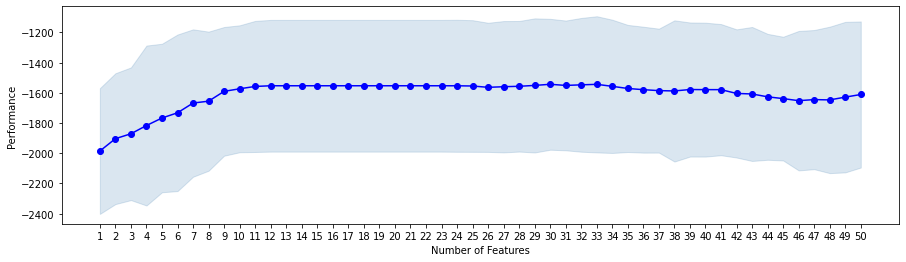

In [ ]:
fig1 = plot_sfs(features.get_metric_dict(), kind='std_dev')

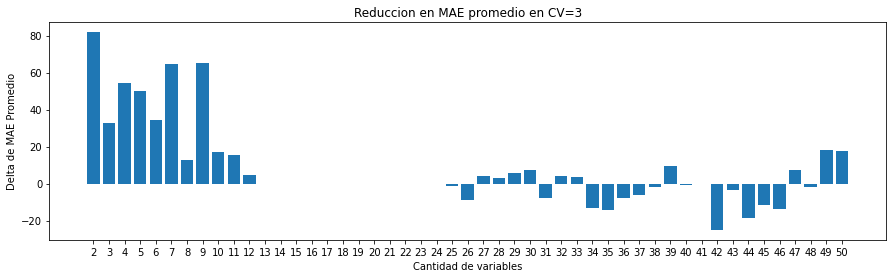

In [ ]:
diferencias_mae=results['avg_score']-results['avg_score'].shift(1)
plt.figure(figsize=(15, 4))
plt.bar(results.index[1:],diferencias_mae[1:])
plt.xticks(results.index[1:])
plt.title('Reduccion en MAE promedio en CV=3')
plt.xlabel('Cantidad de variables')
plt.ylabel('Delta de MAE Promedio')
plt.show()

Como vemos aqui, la ganancia de adicionar features despues de los primeros 12 es practicamente nula por varias iteraciones, por lo que optaremos en usar solo 12 variables o features seleccionados por el algoritmo.

In [ ]:
n_features=12
list(results.feature_names[12])
inputs_subset_model1=base_inputs[[c for c in base_inputs.columns if c in list(results.feature_names[30]) ]]

In [ ]:
results.head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(61,)","[-1581.993032739743, -1815.0047520919618, -255...",-1985.18,"(log_turismo,)",937.112,416.433,294.463
2,"(14, 61)","[-1487.697014522397, -1721.5136950593624, -250...",-1903.4,"(border_closure, log_turismo)",974.873,433.213,306.328
3,"(14, 54, 61)","[-1502.260513592294, -1621.8781135098213, -248...",-1870.78,"(border_closure, n_cities_1, log_turismo)",988.572,439.301,310.633
4,"(14, 54, 59, 61)","[-1330.1045864481098, -1566.1522139892957, -25...",-1816.3,"(border_closure, n_cities_1, log_gdp_per_capit...",1191.6,529.522,374.429
5,"(8, 14, 54, 59, 61)","[-1342.5913232397934, -1500.6614492152135, -24...",-1766.38,"(diabetes_prevalence, border_closure, n_cities...",1106.74,491.813,347.764


## Optimizacion de Hiperparametros

En esta parte del codigo optimizaremos nuestro modelo LGBMRegressor para que tenga la combinacion optima de parametros, que maximice la predictibilidad segun las metricas de la competencia.

In [ ]:
reg=model1

rf_space  = [Integer(1, 5, name='regressor__max_depth'),
          Integer(1, 27, name='regressor__max_features'),
          Integer(10,50,name='regressor__n_estimators'),
          Integer(1, 10, name='regressor__min_samples_split'),
          Integer(1, 10, name='regressor__min_samples_leaf'),
          Real(10**-5,10**0,'log-uniform',name='regressor__learning_rate')]

@use_named_args(rf_space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, inputs_subset_model1, Y, cv=strat_k_fold, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))
res_gp = gp_minimize(objective, rf_space, n_calls=50, random_state=0)

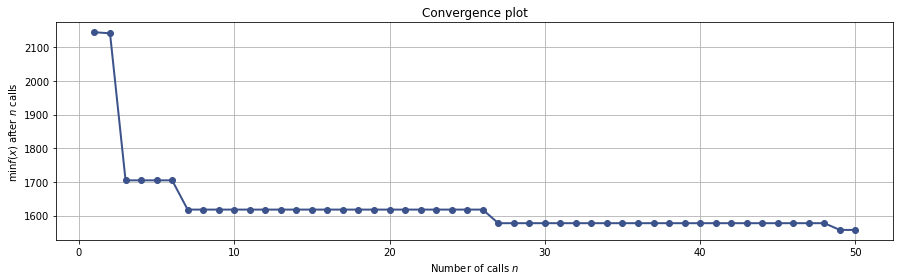

In [ ]:
plot_convergence(res_gp)

In [ ]:
best_vals_model1=res_gp.x
best_vals_model1

[3, 12, 33, 8, 9, 0.3613755526951507]

In [ ]:
mod1=model1.set_params(**{'regressor__max_depth':best_vals_model1[0],'regressor__max_features':best_vals_model1[1],'regressor__n_estimators':best_vals_model1[2],'regressor__min_samples_split':best_vals_model1[3],
                 'regressor__min_samples_leaf':best_vals_model1[4],'regressor__learning_rate':best_vals_model1[5]})
preds1=cross_val_predict(mod1,inputs_subset_model1,Y,cv=strat_k_fold)



## Resultados

Ya con nuestro modelo final optimizado, podemos proceder a hacer nuestros pronosticos y evaluar el error que obtenemos segun las metricas de la competencia

In [ ]:
resultado_single_models=pd.DataFrame({'Country':base_completa.country_x,'Predicted':preds1,'Real':Y})
resultado_single_models['error_absoluto']=np.abs(resultado_single_models['Predicted']-resultado_single_models['Real'])
resultado_single_models.sort_values(by='error_absoluto',ascending=False)

,Country,Predicted,Real,error_absoluto
186,Turkey,7139.460068,61049,53909.539932
38,China,509.496559,40236,39726.503441
95,Italy,16327.053806,53578,37250.946194
172,Spain,18966.259831,47610,28643.740169
90,Iran (Islamic Republic of),691.572453,20610,19918.427547
...,...,...,...,...
76,Grenada,21.883120,20,1.883120
35,Central African Republic,93.052682,94,0.947318
182,Timor-Leste,24.833099,24,0.833099
26,Brunei Darussalam,134.473210,135,0.526790


In [ ]:
np.mean(resultado_single_models['error_absoluto'])

1557.5503364414667

In [ ]:
def evaluate(model, X, Y):
    strat_k_fold = KFold(n_splits=3, shuffle=True, random_state=2020)
    mae = make_scorer(mean_absolute_error)
    return np.mean(cross_val_score(model, X, Y, scoring = mae, cv = strat_k_fold))

Aqui veremos nuestro resultado oficial para la competencia:

In [ ]:
evaluate(mod1,inputs_subset_model1,Y)

1557.5503364414665

## Adicional: Importancia de variables

Ya conocemos el performance de nuestro modelo, pero ademas de ver el desempeño, podemos observar cuales variables el modelo usa para hacer varios "splits" y asi inferir que tan importantes son estas variables para el desempeño del modelo.

In [ ]:
resultado_importancia=cross_validate(mod1,inputs_subset_model1,Y,return_estimator=True,cv=strat_k_fold)

In [ ]:
data=pd.DataFrame(index=inputs_subset_model1.columns)
for idx,estimator in enumerate(resultado_importancia['estimator']):
    col='importance_'+str(idx)
    feature_importances = pd.DataFrame(estimator.regressor_.feature_importances_,
                                       index = inputs_subset_model1.columns,
                                        columns=[col])
    data=pd.merge(data,feature_importances,left_index=True,right_index=True)

In [ ]:
data['importancia_promedio']=data.mean(axis=1)
data['importancia_sd']=data.std(axis=1)
data.sort_values(by='importancia_promedio',ascending=False)

,importance_0,importance_1,importance_2,importancia_promedio,importancia_sd
diabetes_prevalence,26,11,14,17.000000,6.480741
log_gdp_per_capita,20,16,14,16.666667,2.494438
log_turismo,12,18,19,16.333333,3.091206
male_smokers,12,17,13,14.000000,2.160247
tiempo,11,11,14,12.000000,1.414214
female_smokers,15,8,11,11.333333,2.867442
n_cities_1,3,7,12,7.333333,3.681787
EURO,5,5,7,5.666667,0.942809
n_cities_2,8,5,2,5.000000,2.449490
border_closure,4,3,3,3.333333,0.471405


Text(0.5, 1.0, 'Top 5 variables mas importantes en LGBMRegressor')

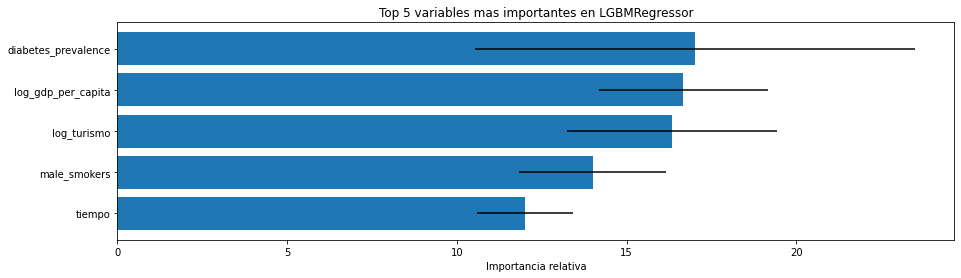

In [ ]:
most_important_vars=data.sort_values(by='importancia_promedio',ascending=False).head()
fig, ax = plt.subplots()
ax.barh(most_important_vars.index,most_important_vars.importancia_promedio,xerr=most_important_vars.importancia_sd)
ax.invert_yaxis()
ax.set_xlabel('Importancia relativa')
ax.set_title('Top 5 variables mas importantes en LGBMRegressor')